max point: [0.18367346938775508, -0.7959183673469388] -> 7.758621630113235


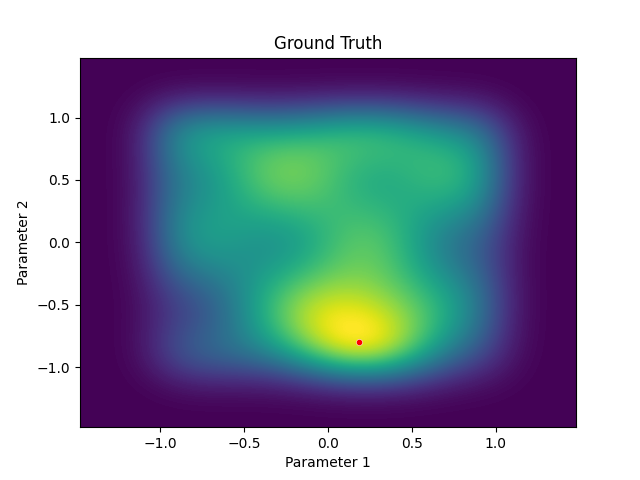

In [25]:
%matplotlib widget
"""
    We create a random 2D function to test out the parallel Bayesion optimization
    algorithm. The function is a simple sum of two sinusoidal functions. The
    algorithm should be able to find the maximum point in the function.
"""
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
np.random.seed(100)

# create a random 2D function to learn
def f(x):
    return (
        5
        * np.exp(
            -(((x[0] - 0.2) ** 2) / (2 * (0.1)) + ((x[1] + 0.7) ** 2) / (2 * (0.1)))
        )
        + np.cos(x[0] * 2.0)
        + np.sin(x[1] * 2.0)
        + np.cos(x[1] * 6.0) * np.sin(x[0] * 6.0)
        + 3
    )


# plot the function in 3D
fig = plt.figure()
ax = fig.add_subplot(111)
x1 = np.linspace(-1, 1, 50)
x2 = np.linspace(-1, 1, 50)
X1, X2 = np.meshgrid(x1, x2, indexing="ij")
Y = f([X1, X2])
# ax.plot_surface(X1, X2, Y, cmap="viridis", alpha=0.5)
sns.kdeplot(x=X1.ravel(), y=X2.ravel(), weights=Y.ravel(), fill=True, thresh=0, levels=500, cmap="viridis")

# get the max point, this is the ground truth
max_point = np.unravel_index(Y.argmax(), Y.shape)
max_x = [x1[max_point[0]], x2[max_point[1]]]
max_y = f(max_x)
# ax.scatter(max_x[0], max_x[1], max_y, color="r")
sns.scatterplot(x=np.array([max_x[0]]), y=np.array([max_x[1]]), color="r", s=20)
ax.set_xlabel("Parameter 1")
ax.set_ylabel("Parameter 2")
ax.set_title("Ground Truth")
print(f"max point: {max_x} -> {max_y}")
ground_truth = max_x

In [26]:
from botorch import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.acquisition.logei import qLogNoisyExpectedImprovement
from botorch.optim import optimize_acqf
from torch import Tensor, double, Size
from botorch.sampling import SobolQMCNormalSampler
from gpytorch import ExactMarginalLogLikelihood

# now get some initial data points from the function for initialization
# sample equadistant points across surface
n_points = 5
X_train = Tensor(
    np.array([[0, 0], [-0.5, -0.5], [-0.5, 0.5], [0.5, 0.5], [0.5, -0.5]])
).type(double)

# evaluate the function at the points
noise = 0.01
Y_train = (
    Tensor(np.array([f(x) for x in X_train]) + np.random.normal(0, noise, n_points))
    .type(double)
    .reshape(-1, 1)
)

num_iter = 4
for i in range(num_iter):
    model = SingleTaskGP(X_train, Y_train)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    mll = fit_gpytorch_mll(mll)
    sampler = SobolQMCNormalSampler(Size([1024]))
    qLogNEI = qLogNoisyExpectedImprovement(model, X_train, sampler)
    bounds = Tensor([[-1.0, -1.0], [1.0, 1.0]])
    new_X, _ = optimize_acqf(
        qLogNEI, bounds=bounds, q=n_points, num_restarts=10, raw_samples=100
    )
    new_Y = Tensor(np.array([f(x) for x in new_X])).type(double).reshape(-1, 1)
    if i != num_iter - 1:
        X_train = Tensor(np.vstack((X_train, new_X))).type(double)
        Y_train = Tensor(np.vstack((Y_train, new_Y))).type(double)

/opt/homebrew/lib/python3.10/site-packages/botorch/models/utils/assorted.py:264: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/opt/homebrew/lib/python3.10/site-packages/botorch/models/utils/assorted.py:264: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/opt/homebrew/lib/python3.10/site-packages/botorch/models/utils/assorted.py:264: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/opt/homebrew/lib/python3.10/site-packages/botorch/models/utils/assorted.py:264: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


max point: [tensor(0.1429), tensor(-0.9592)] -> 7.187921524047852


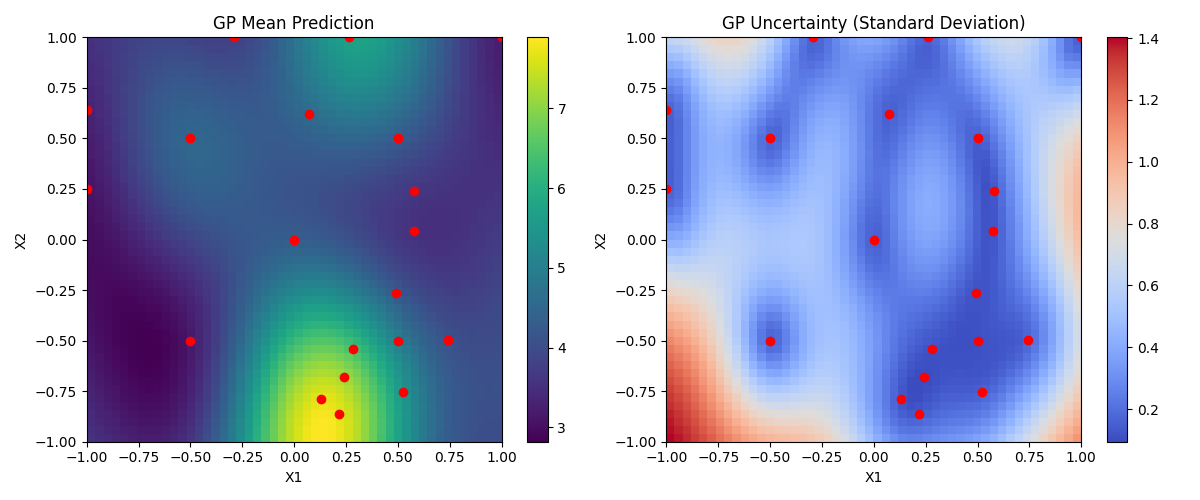

In [27]:
import torch

# Generate a grid of test points
grid_size = 50
x1 = torch.linspace(-1, 1, grid_size)
x2 = torch.linspace(-1, 1, grid_size)
X1, X2 = torch.meshgrid(x1, x2, indexing="ij")
test_X = torch.cat([X1.reshape(-1, 1), X2.reshape(-1, 1)], dim=1)

# Predict using the trained model
model.eval()
with torch.no_grad():
    pred = model.posterior(test_X)
    mean = pred.mean.view(grid_size, grid_size).numpy()
    stddev = pred.variance.sqrt().view(grid_size, grid_size).numpy()

# Plot mean predictions
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Mean Prediction Heatmap
c1 = ax[0].imshow(
    mean.T, extent=[-1, 1, -1, 1], origin="lower", cmap="viridis", aspect="auto"
)
ax[0].scatter(X_train[:, 0], X_train[:, 1], color="r", marker="o", label="Train Data")
ax[0].set_title("GP Mean Prediction")
ax[0].set_xlabel("X1")
ax[0].set_ylabel("X2")
fig.colorbar(c1, ax=ax[0])

# Uncertainty (Standard Deviation) Heatmap
c2 = ax[1].imshow(
    stddev.T, extent=[-1, 1, -1, 1], origin="lower", cmap="coolwarm", aspect="auto"
)
ax[1].scatter(X_train[:, 0], X_train[:, 1], color="r", marker="o", label="Train Data")
ax[1].set_title("GP Uncertainty (Standard Deviation)")
ax[1].set_xlabel("X1")
ax[1].set_ylabel("X2")
fig.colorbar(c2, ax=ax[1])

plt.tight_layout()

# return the max point
max_point = np.unravel_index(mean.argmax(), mean.shape)
max_x = [x1[max_point[0]], x2[max_point[1]]]
max_y = f(max_x)
print(f"max point: {max_x} -> {max_y}")